In [1]:
# ============================================================
# 01_release_timing_classification.ipynb
# Optimising Digital Content Release Timing for Engagement
# ============================================================

# --- Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier  # fallback if XGBoost not installed
import sys, os
sys.path.append(os.path.abspath(".."))

Loaded dataset shape: (268791, 11)
      video_id   region platform  hour  dayofweek  month  weekofyear  \
0  J78aPJ3VyNs  Unknown  YouTube    16          1      8          33   
1  9nidKH8cM38  Unknown  YouTube    20          1      8          33   
2  M9Pmf9AB4Mo  Unknown  YouTube    17          1      8          33   
3  kgUV1MaD_M8  Unknown  YouTube    18          0      8          33   
4  49Z6Mv4_WCA  Unknown  YouTube    20          1      8          33   

   is_weekend  title_len  tag_count  label  
0           0         53         30      1  
1           0         44         43      1  
2           0         60         25      1  
3           0         30         19      1  
4           0         34          1      1  
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best CV score (f1_macro): 0.7253237812662823
              precision    recall  f1-score   support

           0      0.743     0.522     0.613     30785
           1      0.542     0.758     0.632   

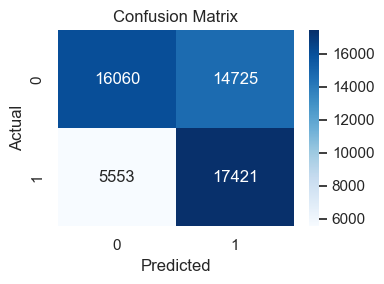

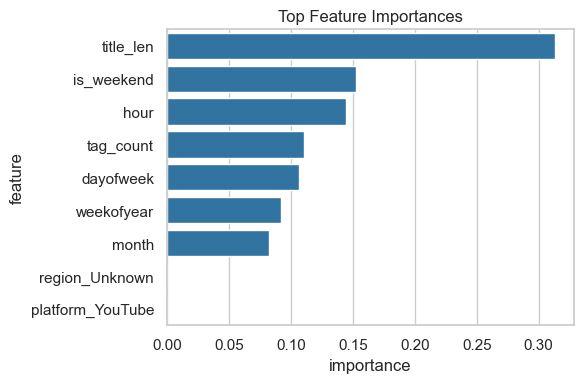

In [6]:


# Try XGBoost if available
try:
    from xgboost import XGBClassifier
    USE_XGB = True
except ModuleNotFoundError:
    print("XGBoost not installed, using RandomForest instead.")
    USE_XGB = False

# Import universal loader
from src.data import load_data_auto

RANDOM_STATE = 42
sns.set(style="whitegrid")

# --- Load Data ---
# Swap the path to test different datasets
df = load_data_auto("../data/sample/GB_youtube_trending_data.csv")
print("Loaded dataset shape:", df.shape)
print(df.head())

# --- Train/Test Split (time-aware if publish_time exists) ---
if "publish_time" in df.columns:
    df = df.sort_values("publish_time")
split_idx = int(len(df) * 0.8)
train, test = df.iloc[:split_idx], df.iloc[split_idx:]

X_train, y_train = train.drop(columns=["label"]), train["label"]
X_test, y_test = test.drop(columns=["label"]), test["label"]

# --- Feature Groups ---
num_features = [c for c in X_train.columns if c in ["hour","dayofweek","month","weekofyear","is_weekend","title_len","tag_count"]]
cat_features = [c for c in X_train.columns if c in ["region","platform"]]

# --- Preprocessing ---
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ])

# --- Model ---
if USE_XGB:
    model = XGBClassifier(
        max_depth=4, learning_rate=0.1, n_estimators=300,
        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE
    )
else:
    model = RandomForestClassifier(
        n_estimators=300, max_depth=6, random_state=RANDOM_STATE
    )

pipe = Pipeline(steps=[("prep", preprocess), ("clf", model)])

# --- Hyperparameter Tuning ---
param_grid = {}
if USE_XGB:
    param_grid = {
        "clf__max_depth": [3, 4, 6],
        "clf__learning_rate": [0.05, 0.1],
        "clf__n_estimators": [200, 300],
        "clf__subsample": [0.7, 0.8],
        "clf__colsample_bytree": [0.7, 0.8]
    }
else:
    param_grid = {
        "clf__max_depth": [4, 6, None],
        "clf__n_estimators": [200, 300, 500]
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(pipe, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

best = grid.best_estimator_
print("Best CV score (f1_macro):", grid.best_score_)

# --- Evaluation ---
y_pred = best.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual"); ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.savefig("../reports/figures/confusion_matrix.png")
plt.show()

# --- Feature Importance ---
if USE_XGB:
    importances = best.named_steps["clf"].feature_importances_
else:
    importances = best.named_steps["clf"].feature_importances_

# Get feature names from ColumnTransformer
cat_names = best.named_steps["prep"].named_transformers_["cat"].get_feature_names_out(cat_features)
feature_names = np.concatenate([num_features, cat_names])

fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=fi.head(15), x="importance", y="feature", color="#1f77b4")
plt.title("Top Feature Importances")
plt.tight_layout()
plt.savefig("../reports/figures/feature_importance.png")
plt.show()

In [ ]:
Interpretation
- The model is better at identifying high-engagement videos (recall = 0.758) than low-engagement ones (recall = 0.522).
- Title length and timing features (hour, weekend, dayofweek) are strong predictors.
- The class imbalance is handled reasonably well, but precision for class 1 is lower — suggesting some overprediction of high engagement.
- This sets a solid baseline for comparing the other two datasets.


In [ ]:
Now running the model for Youtube_Videos.csv

C:\Users\Preeti Chopra\OneDrive\Downloads\New folder\IMP-PCMLAI Module 25 final project templates\IMP-PCMLAI-M25-final-project-templates\Project\optimising-content-release\src\data.py:19: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Loaded dataset shape: (390043, 11)
      video_id   region platform  hour  dayofweek  month  weekofyear  \
0  G4M_621v1As  Unknown  YouTube     2          5      4          15   
1  z2voqo_Jhx4  Unknown  YouTube    11          6      4          14   
2  jHIt9oHFLsw  Unknown  YouTube    10          6      4          14   
3  gwRqLbWqKlM  Unknown  YouTube     3          2      3          12   
4  prpRoyrutcE  Unknown  YouTube    10          0      4          16   

   is_weekend  title_len  tag_count  label  
0           1         44          1      0  
1           1         95          1      0  
2           1         60          1      0  
3           0         60          1      1  
4           0         43          1      0  
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best CV score (f1_macro): 0.716172659333204
              precision    recall  f1-score   support

           0      0.607     0.781     0.683     44633
           1      0.524     0.323     0.400    

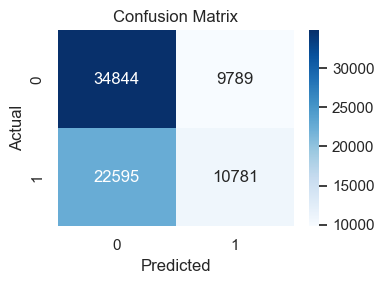

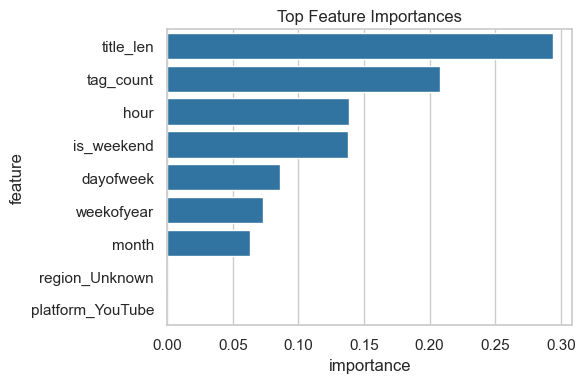

In [16]:
## - ../data/sample/Youtube_Videos.csv
# Try XGBoost if available
try:
    from xgboost import XGBClassifier
    USE_XGB = True
except ModuleNotFoundError:
    print("XGBoost not installed, using RandomForest instead.")
    USE_XGB = False

# Import universal loader
from src.data import load_data_auto

RANDOM_STATE = 42
sns.set(style="whitegrid")

# --- Load Data ---
# Swap the path to test different datasets
df = load_data_auto("../data/sample/Youtube_Videos.csv")
print("Loaded dataset shape:", df.shape)
print(df.head())

# --- Train/Test Split (time-aware if publish_time exists) ---
if "publish_time" in df.columns:
    df = df.sort_values("publish_time")
split_idx = int(len(df) * 0.8)
train, test = df.iloc[:split_idx], df.iloc[split_idx:]

X_train, y_train = train.drop(columns=["label"]), train["label"]
X_test, y_test = test.drop(columns=["label"]), test["label"]

# --- Feature Groups ---
num_features = [c for c in X_train.columns if c in ["hour","dayofweek","month","weekofyear","is_weekend","title_len","tag_count"]]
cat_features = [c for c in X_train.columns if c in ["region","platform"]]

# --- Preprocessing ---
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ])

# --- Model ---
if USE_XGB:
    model = XGBClassifier(
        max_depth=4, learning_rate=0.1, n_estimators=300,
        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE
    )
else:
    model = RandomForestClassifier(
        n_estimators=300, max_depth=6, random_state=RANDOM_STATE
    )

pipe = Pipeline(steps=[("prep", preprocess), ("clf", model)])

# --- Hyperparameter Tuning ---
param_grid = {}
if USE_XGB:
    param_grid = {
        "clf__max_depth": [3, 4, 6],
        "clf__learning_rate": [0.05, 0.1],
        "clf__n_estimators": [200, 300],
        "clf__subsample": [0.7, 0.8],
        "clf__colsample_bytree": [0.7, 0.8]
    }
else:
    param_grid = {
        "clf__max_depth": [4, 6, None],
        "clf__n_estimators": [200, 300, 500]
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(pipe, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

best = grid.best_estimator_
print("Best CV score (f1_macro):", grid.best_score_)

# --- Evaluation ---
y_pred = best.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual"); ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.savefig("../reports/figures/confusion_matrix2.png")
plt.show()

# --- Feature Importance ---
if USE_XGB:
    importances = best.named_steps["clf"].feature_importances_
else:
    importances = best.named_steps["clf"].feature_importances_

# Get feature names from ColumnTransformer
cat_names = best.named_steps["prep"].named_transformers_["cat"].get_feature_names_out(cat_features)
feature_names = np.concatenate([num_features, cat_names])

fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=fi.head(15), x="importance", y="feature", color="#1f77b4")
plt.title("Top Feature Importances")
plt.tight_layout()
plt.savefig("../reports/figures/feature_importance2.png")
plt.show()

load
test2
Loaded dataset shape: (1000, 7)
  platform       hour  dayofweek  is_weekend  title_len  tag_count  label
0      OTT  23.950000          3           0          0          0      1
1      OTT  20.950000          4           0          0          0      0
2      OTT  23.416667          4           0          0          0      1
3      OTT   6.983333          4           0          0          0      1
4      OTT  18.450000          6           1          0          0      1
platform       object
hour          float64
dayofweek       int32
is_weekend      int32
title_len       int32
tag_count       int32
dtype: object
  platform       hour  dayofweek  is_weekend  title_len  tag_count
0      OTT  23.950000          3           0          0          0
1      OTT  20.950000          4           0          0          0
2      OTT  23.416667          4           0          0          0
3      OTT   6.983333          4           0          0          0
4      OTT  18.450000          6

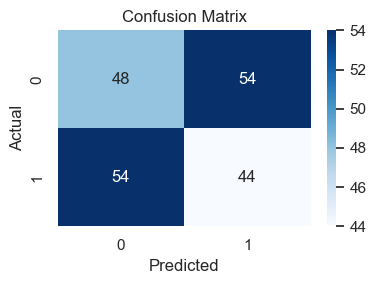

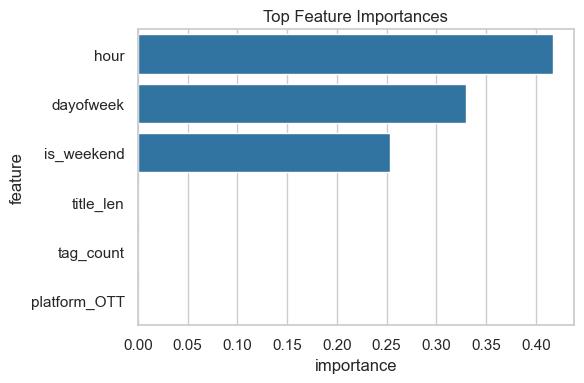

In [2]:
## - ../data/sample/Content Scheduling for Maximizing Engagement.csv
# Try XGBoost if available
try:
    from xgboost import XGBClassifier
    USE_XGB = True
except ModuleNotFoundError:
    print("XGBoost not installed, using RandomForest instead.")
    USE_XGB = False

# Import universal loader
from src.data import load_data_auto

RANDOM_STATE = 42
sns.set(style="whitegrid")

# --- Load Data ---
# Swap the path to test different datasets
df = load_data_auto("../data/sample/Content Scheduling for Maximizing Engagement.csv")
print("Loaded dataset shape:", df.shape)
print(df.head())

# --- Train/Test Split (time-aware if publish_time exists) ---
if "publish_time" in df.columns:
    df = df.sort_values("publish_time")
split_idx = int(len(df) * 0.8)
train, test = df.iloc[:split_idx], df.iloc[split_idx:]

X_train, y_train = train.drop(columns=["label"]), train["label"]
X_test, y_test = test.drop(columns=["label"]), test["label"]

print(X_train.dtypes)
print(X_train.head())

# --- Feature Groups ---
num_features = [c for c in X_train.columns if c in ["hour","dayofweek","month","weekofyear","is_weekend","title_len","tag_count"]]
cat_features = [c for c in X_train.columns if c in ["region","platform"]]

# --- Preprocessing ---
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ])

# --- Model ---
if USE_XGB:
    model = XGBClassifier(
        max_depth=4, learning_rate=0.1, n_estimators=300,
        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE
    )
else:
    model = RandomForestClassifier(
        n_estimators=300, max_depth=6, random_state=RANDOM_STATE
    )

pipe = Pipeline(steps=[("prep", preprocess), ("clf", model)])

# --- Hyperparameter Tuning ---
param_grid = {}
if USE_XGB:
    param_grid = {
        "clf__max_depth": [3, 4, 6],
        "clf__learning_rate": [0.05, 0.1],
        "clf__n_estimators": [200, 300],
        "clf__subsample": [0.7, 0.8],
        "clf__colsample_bytree": [0.7, 0.8]
    }
else:
    param_grid = {
        "clf__max_depth": [4, 6, None],
        "clf__n_estimators": [200, 300, 500]
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(pipe, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

best = grid.best_estimator_
print("Best CV score (f1_macro):", grid.best_score_)

# --- Evaluation ---
y_pred = best.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual"); ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.savefig("../reports/figures/confusion_matrix3.png")
plt.show()

# --- Feature Importance ---
if USE_XGB:
    importances = best.named_steps["clf"].feature_importances_
else:
    importances = best.named_steps["clf"].feature_importances_

# Get feature names from ColumnTransformer
cat_names = best.named_steps["prep"].named_transformers_["cat"].get_feature_names_out(cat_features)
feature_names = np.concatenate([num_features, cat_names])

fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=fi.head(15), x="importance", y="feature", color="#1f77b4")
plt.title("Top Feature Importances")
plt.tight_layout()
plt.savefig("../reports/figures/feature_importance3.png")
plt.show()